In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smt
import statsmodels as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
covid_19 = pd.read_csv('Covid_19_train.csv', index_col="Time", parse_dates=True, dayfirst=True)

In [4]:
data = covid_19['Daily_cases'].copy()
ts = covid_19['Daily_cases']

# Initial data analysis

First of all we do some data analysis, finding the mean of the data and standard deviation of the time series data. We are going to plot the data, to see if there any variable transformation that we should do

In [5]:
data.describe().round(4)

count     205.0000
mean      552.0146
std       403.9527
min         1.0000
25%       239.0000
50%       475.0000
75%       773.0000
max      1685.0000
Name: Daily_cases, dtype: float64

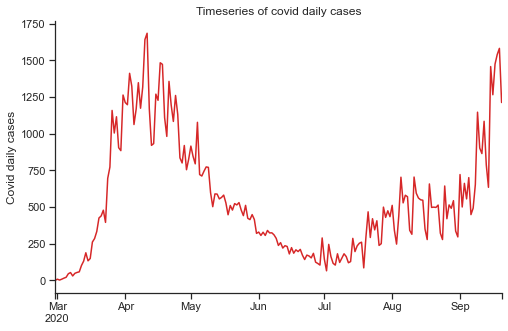

In [6]:
fig, ax= plt.subplots(figsize=(8,5))
data.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Covid daily cases')
ax.set_title('Timeseries of covid daily cases')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

From the graph above there is no clear pattern for seasonality, as it disappears around May to June but appear in other months. There is limitation, we can't seperate seasonality only for certain months. We can't extract the seasonal adjusted data as well as the X13 files given can only be use by monthly or yearly data/not daily data, so in here we are going to ignore seasonality. But we are able to observe the variance along the data is not constant so we logged the timeseries data to make the variance constant. 

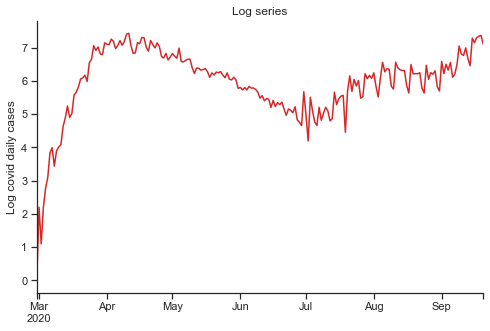

In [7]:
fig, ax= plt.subplots(figsize=(8,5))
np.log(data).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log covid daily cases')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

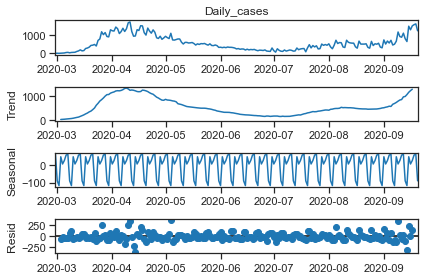

In [8]:
from matplotlib import pyplot
basic_decomposition = smt.tsa.seasonal_decompose(ts)
basic_decomposition.plot()
pyplot.show()

# Simple exponential smoothing

For the first model we did simple exponential smoothing, with non transformed data

In [9]:
#Since we are not able to take the seasonal adjusted data
import forecast
ses=forecast.ses(ts)
ses.fit()
fitted=pd.Series(ses.smooth(), index=ts.index)
ses.summary()
#Alpha is the smoothing parameter range in 0 to 1

 Simple exponential smoothing

 Smoothing parameter:
 alpha  0.558 (0.075) 

 In-sample fit:
 MSE               22796.832
 Log-likelihood   -1319.406
 AIC               2644.812
 BIC               2654.781


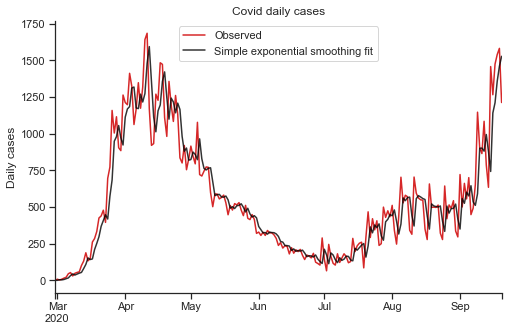

In [10]:
fig, ax= plt.subplots(figsize=(8,5))
ts.plot(color=red, label='Observed')
fitted.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Daily cases')
ax.set_title('Covid daily cases')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

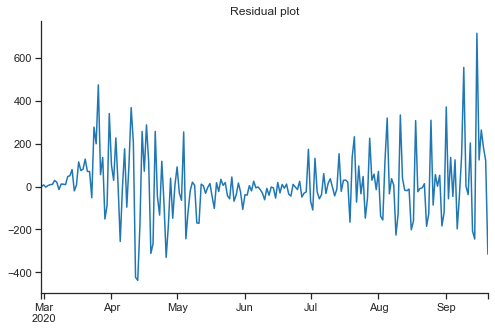

In [11]:
resid=ts-fitted
fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

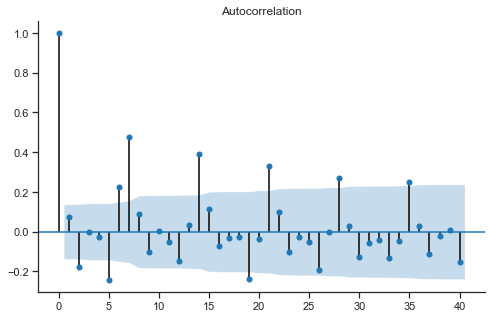

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
smt.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

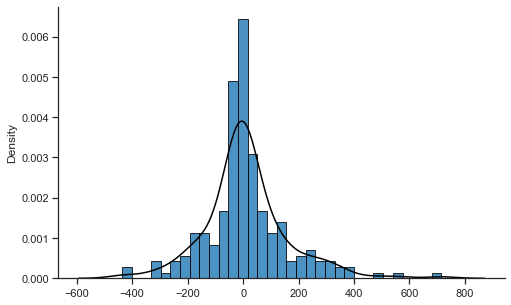

In [13]:
def hist(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

When we perform residual diagnostic, we observed that the most significant autocorrelations are usually around every 7 days each. The residual plot indicate non constant variance. The histogram we plotted show a normally distributed histogram.

The AIC for this model is 2644.812. We will use AIC as our model selection criterion. 

# Trend Corrected Exponential Smoothing

For our second model we did trend corrected exponential smoothing, with log transformed data

In [14]:
log_ts = np.log(ts)

In [15]:
import forecast
holt_log = forecast.holt(log_ts)
holt_log.fit()
holt_log.summary()
smoothed_log=pd.Series(holt_log.smooth(), index=log_ts.index)
#this is what needs to be minimised (MSE specifically)

 Holt (trend corrected) exponential smoothing

 Smoothing parameters: 
 alpha (level) 0.476 (0.065)
 beta (trend)  0.142 (0.050)
 
 In-sample fit:
 MSE               0.120
 Log-likelihood   -73.799
 AIC               153.598
 BIC               163.567


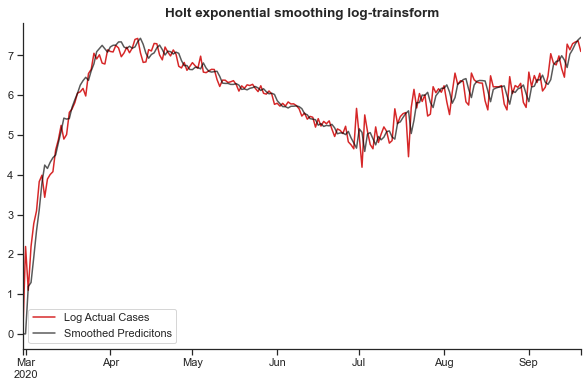

In [16]:
fig, ax= plt.subplots(figsize=(10,6))

log_ts.plot(color='#D62728', label='Log Actual Cases')
smoothed_log.plot(color='black', label='Smoothed Predicitons', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing log-trainsform', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

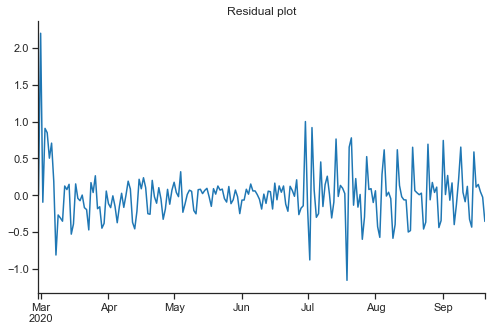

In [17]:
resid_log = (log_ts-holt_log.smooth())

fig, ax= plt.subplots(figsize=(8,5))
resid_log.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

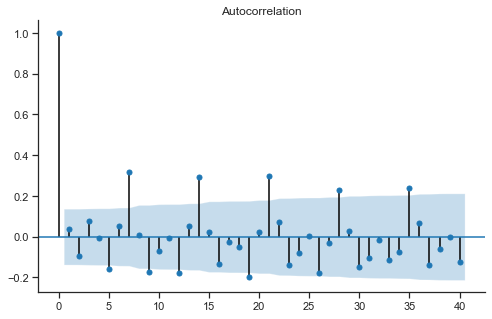

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
smt.graphics.tsa.plot_acf(resid_log, lags=40, ax=ax)
sns.despine()
plt.show()

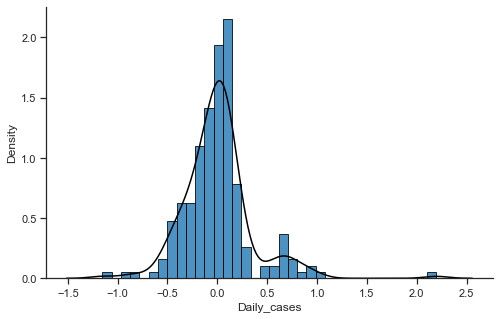

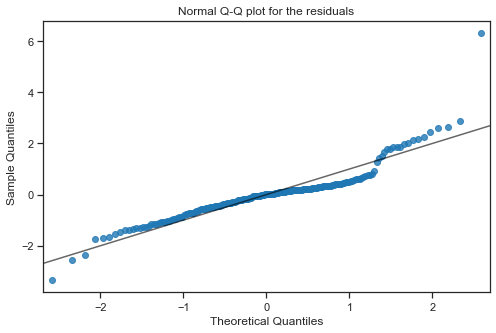

In [19]:
from forecast import histogram, qq_plot
histogram(resid_log)
plt.show()

qq_plot(resid_log)
plt.show()

When we perform residual diagnostic, we observed that the most significant autocorrelations are around every 7 days each. The residual plot indicate non constant variance. The histogram we plotted doesn't show a normally distributed histogram, its appear more right skewed. There is no significant departure on the qqplot. Based on the qqplot, the residuals are appproximately normally distributed.

The AIC for this model is 153.598. This is much lower than AIC of simple exponential smoothing that we have done before (2644.812). 

# Test for stationary and data transformation

In [20]:
# test stationarity for the original model
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

# now, given a time series ts

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.771276
p-value                          0.394813
#Lags Used                      13.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


Dickey-Fuller test for the original time series data without any transformation gave us a high p-value (0.394813). So we decide to do data transformation (Log and 1st differencing). we do log transformation to make the variance constant across our data as mentioned before in the IDA. 1st differencing is being choosen to remove seasonality and trend from the data (to make the data stationary), we should be careful to not to overdifferencing the data so we always choose a smaller number of diffrencing.

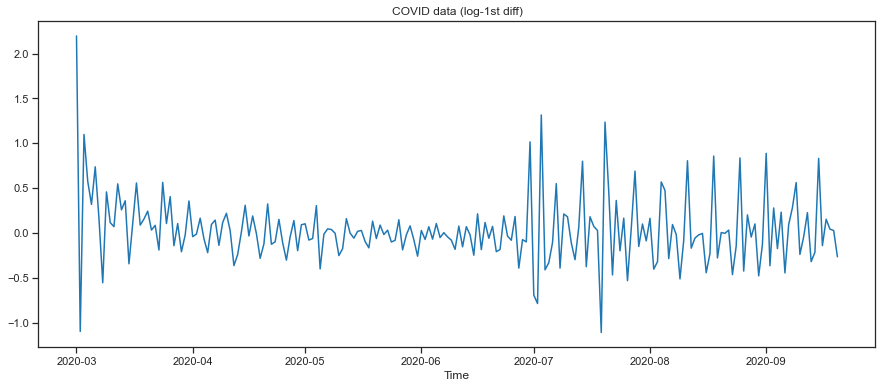

Results of Dickey-Fuller Test:
Test Statistic                  -3.750794
p-value                          0.003453
#Lags Used                      10.000000
Number of Observations Used    193.000000
Critical Value (1%)             -3.464694
Critical Value (5%)             -2.876635
Critical Value (10%)            -2.574816
dtype: float64


In [21]:
#Do log transformation, since the variation of the data is not constant
ts_log = np.log(ts) 
# take the 1st order diff
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

# Plot the 1st-differencing series
plt.figure(figsize = (15,6))
plt.plot(ts_log_diff)
plt.title("COVID data (log-1st diff)")
plt.xlabel('Time')
plt.show()


test_stationarity(ts_log_diff)

By applying log transformation on the observed time series and then do 1st differencing on the time series data, we manage to get a small p-value (0.003453) which indicate the time series data is stationary. The next step we will fit the "transformed"/"stationary" time series data to AR,MA and ARIMA model.

# AR (Auto Regressive) Models

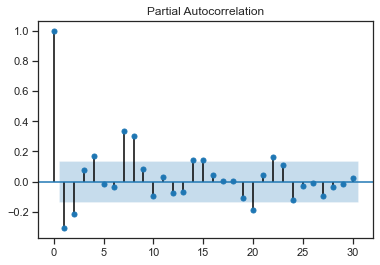

In [22]:
# For log and differenced time series
smt.graphics.tsa.plot_pacf(ts_log_diff, lags=30, alpha = 0.05)
plt.show()

Looking at the Partial autocorrelation plot, we can set our max_AR as 4. Since the 4th lag looks like the cuts off point of our PACF plot (the plots seems dies down after 4th lag). Checking it with more formal way, the AIC method below.

In [23]:
#Using AIC to select order
import statsmodels.tsa.stattools as st 
import warnings
warnings.filterwarnings("ignore") # turing off Python warning about future release related to the following code

order_AR = st.arma_order_select_ic(ts_log_diff,max_ar=4,max_ma=0,ic=['aic'])
order_AR

{'aic':             0
 0  187.553479
 1  165.096679
 2  157.009081
 3  158.237637
 4  155.688709,
 'aic_min_order': (4, 0)}

In [24]:
# Import ARIMA class
from statsmodels.tsa.arima_model import ARIMA
# Create an AR() model
model_AR = ARIMA(ts_log, order=(4, 1, 0))
model_AR_fit = model_AR.fit()
# summary of fit model
print(model_AR_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Daily_cases   No. Observations:                  204
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 -71.844
Method:                       css-mle   S.D. of innovations              0.344
Date:                Tue, 16 Nov 2021   AIC                            155.689
Time:                        20:53:09   BIC                            175.597
Sample:                    03-01-2020   HQIC                           163.742
                         - 09-20-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0338      0.019      1.813      0.070      -0.003       0.070
ar.L1.D.Daily_cases    -0.4128      0.076     -5.466      0.000      -0.561      -0.265
ar.L2.D.Daily_ca

AR (4,1,0) model has one insignificant coefficient ar.L3. We move to the other order with the second lowest AIC, Our second model is AR (2,1,0) with AIC of 157.009, which is not far compared to our current AR model (AR (4,1,0) has 155.689)

In [25]:
# Import ARIMA class
from statsmodels.tsa.arima_model import ARIMA
# Create an AR() model
model_AR_2 = ARIMA(ts_log, order=(2, 1, 0))
model_AR_fit_2 = model_AR_2.fit()
# summary of fit model
print(model_AR_fit_2.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Daily_cases   No. Observations:                  204
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -74.505
Method:                       css-mle   S.D. of innovations              0.348
Date:                Tue, 16 Nov 2021   AIC                            157.009
Time:                        20:53:09   BIC                            170.282
Sample:                    03-01-2020   HQIC                           162.378
                         - 09-20-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0319      0.015      2.181      0.029       0.003       0.061
ar.L1.D.Daily_cases    -0.4314      0.073     -5.913      0.000      -0.574      -0.288
ar.L2.D.Daily_ca

The AR model (2,1,0) has AIC of 157.009 with all coefficient is lower than 0.05 (indicate all coefficients are significant), the AIC value is higher than the Simple Exponential Smoothing, but lower than the Holt winter model.

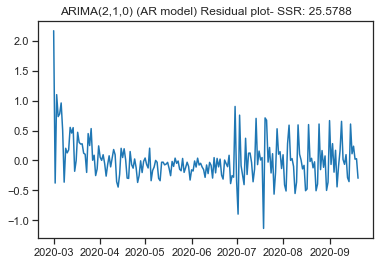

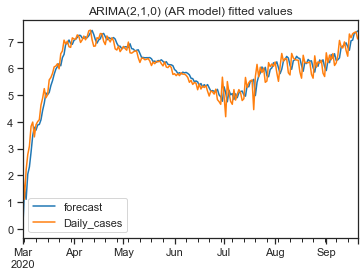

In [26]:
residuals_AR = pd.DataFrame(model_AR_fit_2.resid)

# Plot residual and calculate sum of squared residual (SSR)
plt.figure()
plt.plot(residuals_AR)
plt.title('ARIMA(2,1,0) (AR model) Residual plot- SSR: %.4f'% sum((model_AR_fit_2.resid.values)**2))
plt.show()

# Get Fitted Series
fitted_AR = model_AR_fit_2.predict(typ = 'levels', dynamic = False)

# Actual vs Fitted
model_AR_fit_2.plot_predict(dynamic=False)
plt.title("ARIMA(2,1,0) (AR model) fitted values")
plt.show()

# MA (Moving Average) Model

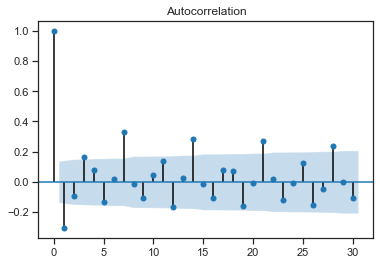

In [27]:
# For log and differenced time series
smt.graphics.tsa.plot_acf(ts_log_diff, lags=30, alpha = 0.05)
plt.show()

Looking at the Autocorrelation plot, we can set our max_MA as 3. Since the 3th lag looks like the cuts off point of our ACF plot (the plots seems dies down after 3th lag). Checking it with more formal way, the AIC method below.

In [28]:
#Using AIC to select order
import statsmodels.tsa.stattools as st 
import warnings
warnings.filterwarnings("ignore") # turing off Python warning about future release related to the following code

order_MA = st.arma_order_select_ic(ts_log_diff,max_ar=0,max_ma=3,ic=['aic'])
order_MA

{'aic':             0           1           2           3
 0  187.553479  159.873816  160.638951  158.504027,
 'aic_min_order': (0, 3)}

In [29]:
# Import ARIMA class
from statsmodels.tsa.arima_model import ARIMA
# Create an MA() model
model_MA = ARIMA(ts_log, order=(0, 1, 3))
model_MA_fit = model_MA.fit()
# summary of fit model
print(model_MA_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Daily_cases   No. Observations:                  204
Model:                 ARIMA(0, 1, 3)   Log Likelihood                 -74.252
Method:                       css-mle   S.D. of innovations              0.348
Date:                Tue, 16 Nov 2021   AIC                            158.504
Time:                        20:53:11   BIC                            175.095
Sample:                    03-01-2020   HQIC                           165.215
                         - 09-20-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0330      0.017      1.998      0.046       0.001       0.065
ma.L1.D.Daily_cases    -0.4194      0.077     -5.456      0.000      -0.570      -0.269
ma.L2.D.Daily_ca

MA (0,1,3) model has one insignificant coefficient ma.L2. We move to the other order with the second lowest AIC, Our second model is MA (0,1,1) with AIC of 159.874, which is not far compared to our current MA model (MA (0,1,3) has 158.504)

In [30]:
# Import ARIMA class
from statsmodels.tsa.arima_model import ARIMA
# Create an MA() model
model_MA_2 = ARIMA(ts_log, order=(0, 1, 1))
model_MA_fit_2 = model_MA_2.fit()
# summary of fit model
print(model_MA_fit_2.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Daily_cases   No. Observations:                  204
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -76.937
Method:                       css-mle   S.D. of innovations              0.353
Date:                Tue, 16 Nov 2021   AIC                            159.874
Time:                        20:53:11   BIC                            169.828
Sample:                    03-01-2020   HQIC                           163.901
                         - 09-20-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0316      0.015      2.119      0.034       0.002       0.061
ma.L1.D.Daily_cases    -0.3984      0.060     -6.677      0.000      -0.515      -0.281
                

The MA model (0,1,1) has AIC of 159.874 with all coefficient is lower than 0.05 (indicate all coefficients are significant), the AIC value is higher than the Simple Exponential Smoothing and AR model, but lower than the Holt winter model.

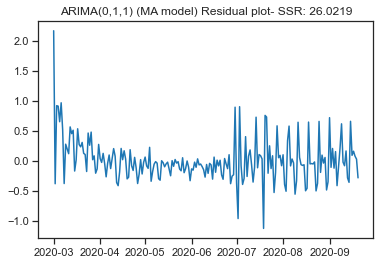

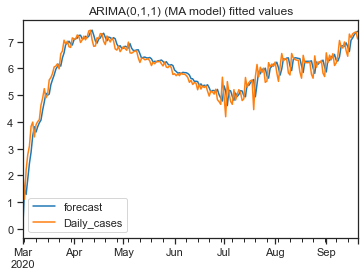

In [31]:
residuals_MA = pd.DataFrame(model_MA_fit_2.resid)

# Plot residual and calculate sum of squared residual (SSR)
plt.figure()
plt.plot(residuals_MA)
plt.title('ARIMA(0,1,1) (MA model) Residual plot- SSR: %.4f'% sum((model_MA_fit_2.resid.values)**2))
plt.show()

# Get Fitted Series
fitted_MA = model_MA_fit_2.predict(typ = 'levels', dynamic = False)

# Actual vs Fitted
model_MA_fit_2.plot_predict(dynamic=False)
plt.title("ARIMA(0,1,1) (MA model) fitted values")
plt.show()

# ARIMA (Auto Regressive Integrated Moving Average)

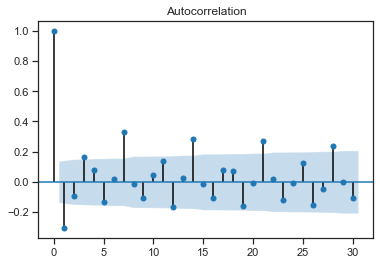

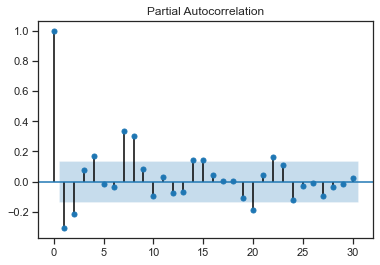

In [32]:
# Sample ACF for MA model
smt.graphics.tsa.plot_acf(ts_log_diff, lags=30, alpha = 0.05)
plt.show()

# Sample PACF for AR model
smt.graphics.tsa.plot_pacf(ts_log_diff, lags=30, alpha = 0.05)
plt.show()

Looking at the PACF and ACF plot above, we decide to set our max_MA and max_AR as 3 and 4 respectively, we will check this combination with the more formal method (AIC method)

In [33]:
#Using AIC to select order
import statsmodels.tsa.stattools as st 
import warnings
warnings.filterwarnings("ignore") # turing off Python warning about future release related to the following code

order = st.arma_order_select_ic(ts_log_diff,max_ar=4,max_ma=3,ic=['aic'])
order

{'aic':             0           1           2           3
 0  187.553479  159.873816  160.638951  158.504027
 1  165.096679  161.297068  159.038027  160.405635
 2  157.009081  158.691597  144.788837  116.767126
 3  158.237637  141.695326  120.252315  117.510145
 4  155.688709  140.871518  115.665789  126.926200,
 'aic_min_order': (4, 2)}

In [34]:
# Import ARIMA class
p,q = 4,2
from statsmodels.tsa.arima_model import ARIMA
# Create an ARIMA() model
model_ARIMA = ARIMA(ts_log, order=(p, 1, q))
model_ARIMA_fit = model_ARIMA.fit(disp=-1)
# summary of fit model
print(model_ARIMA_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Daily_cases   No. Observations:                  204
Model:                 ARIMA(4, 1, 2)   Log Likelihood                 -49.833
Method:                       css-mle   S.D. of innovations              0.302
Date:                Tue, 16 Nov 2021   AIC                            115.666
Time:                        20:53:27   BIC                            142.211
Sample:                    03-01-2020   HQIC                           126.404
                         - 09-20-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1448      0.133      1.086      0.277      -0.116       0.406
ar.L1.D.Daily_cases     1.2676      0.075     16.845      0.000       1.120       1.415
ar.L2.D.Daily_ca

ARIMA(4,1,2) model has two insignificant coefficient ar.L3 and ar.L2. We move to the other combination with the second lowest AIC, Our second model is ARIMA(2,1,3) with AIC of 116.767, which is not far compared to our current ARIMA model (ARIMA(4,1,2) has 115.666)

In [35]:
# Import ARIMA class
p,q = 2,3
from statsmodels.tsa.arima_model import ARIMA
# Create an ARIMA() model
model_ARIMA_2 = ARIMA(ts_log, order=(p, 1, q))
model_ARIMA_fit_2 = model_ARIMA_2.fit(disp=-1)
# summary of fit model
print(model_ARIMA_fit_2.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Daily_cases   No. Observations:                  204
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 -51.384
Method:                       css-mle   S.D. of innovations              0.306
Date:                Tue, 16 Nov 2021   AIC                            116.767
Time:                        20:53:29   BIC                            139.994
Sample:                    03-01-2020   HQIC                           126.163
                         - 09-20-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1485      0.139      1.070      0.285      -0.124       0.421
ar.L1.D.Daily_cases     0.1053      0.040      2.607      0.009       0.026       0.184
ar.L2.D.Daily_ca

In ARIMA(2,1,3) model all coefficient has p-value less than 0.05 indicate all coefficient is significant, we choose this as our final ARIMA model

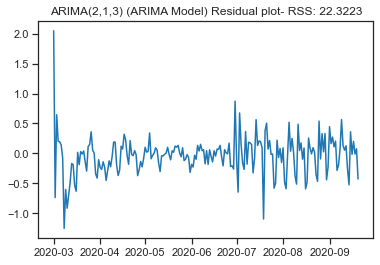

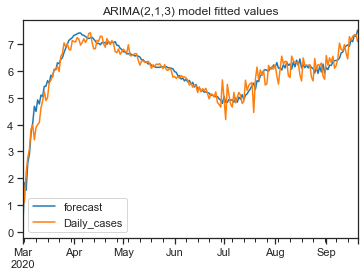

In [36]:
residuals_ARIMA = pd.DataFrame(model_ARIMA_fit_2.resid)

# Plot residual and calculate sum of squared residual (SSR)
plt.figure()
plt.plot(residuals_ARIMA)
plt.title('ARIMA(2,1,3) (ARIMA Model) Residual plot- RSS: %.4f'% sum((model_ARIMA_fit_2.resid.values)**2))
plt.show()

# Get Fitted Series
fitted_ARIMA = model_ARIMA_fit_2.predict(typ = 'levels', dynamic = False)

# Actual vs Fitted
model_ARIMA_fit_2.plot_predict(dynamic=False)
plt.title("ARIMA(2,1,3) model fitted values")
plt.show()

In [37]:
output = model_ARIMA_fit_2.forecast(steps=15)
yhat = output[0]
unlog_yhat = np.exp(yhat)
unlog_yhat

array([1563.02905726, 2030.35196099, 1818.72859222, 2268.5274944 ,
       2111.19784323, 2550.98045411, 2447.18531526, 2884.46417707,
       2834.70239178, 3277.20580237, 3283.25762949, 3739.14548028,
       3804.14541661, 4282.24051576, 4410.7988336 ])

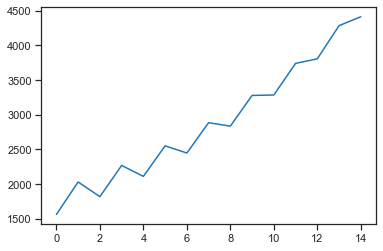

In [38]:
plt.plot(unlog_yhat)

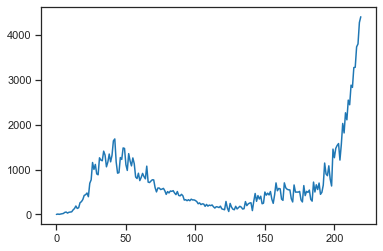

In [39]:
final = np.concatenate((ts, unlog_yhat))
plt.plot(final)

In conclusion the ARIMA(2,1,3) model looks like the best model to forecast our future predictions:
    
1) It has the lowest AIC compared to the other models (MA,AR,simple exponential smoothing and holt winter model), with AIC value of 116.767.

2) The coefficient p-value of model are all less than 0.05. This indicate all the coefficient in the model are significant. On top of that the model parsiminous enough.
    
Final step, we will use this model to produce the test MSE

In [40]:
import pandas as pd 
covid_19_test = pd.read_csv('Covid_19_test.csv')
test_daily_cases = covid_19_test['Daily_cases']

test_data = test_daily_cases.to_numpy()
test_error = np.square(np.subtract(test_data,unlog_yhat)).mean()
print(test_error)

9067143.166020775
